In [1]:
from keras.layers import GRU, Dense, LSTM, TimeDistributed, AlphaDropout, Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Normalization
from keras.layers import Flatten, Dropout, Lambda, Activation, RepeatVector, Permute, Multiply, Resizing, Concatenate, GlobalAveragePooling2D
from keras.models import Sequential, Model, load_model
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.losses import Huber
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping
import joblib
from keras.saving import register_keras_serializable
import os
import tensorflow as tf
import numpy as np
import soundfile as sf
import time
import librosa
import matplotlib.pyplot as plt
from all_models import *

In [32]:
def pad_array(array, max_len, pad_value=0):
    current_len = array.shape[1]  # Assuming mfcc_all contains 2D arrays
    if current_len < max_len:
        pad_width = ((0, 0), (0, max_len - current_len))
        padded_array = np.pad(array, pad_width, mode='constant', constant_values=pad_value)
        return padded_array
    else:
        return array

In [33]:
def wav2spec(filename, hop_length=512, window_size=1024, pad_len=None, pad_value=0):
    y, sr = librosa.load(filename)
    window = np.hanning(window_size)
    out  = librosa.stft(y, n_fft = window_size, hop_length = hop_length, 
        window=window)
    out = 2 * np.abs(out) / np.sum(window)
    amped = librosa.amplitude_to_db(out,ref=np.max)
    if pad_len is not None:
        amped = pad_array(amped, pad_len, pad_value)
    return amped

# Using Spectograms

In [3]:
X = joblib.load('spectogram/indian_spectogram_pca_data.pkl')
y = joblib.load('spectogram/british_spectogram_pca_data.pkl')

In [4]:
X_orig = joblib.load('spectogram/indian_spectogram_data.pkl')
y_orig = joblib.load('spectogram/british_spectogram_data.pkl')

In [4]:
X.shape

(1484, 38, 38)

In [5]:
y.shape

(1484, 38, 38)

In [6]:
n_bins = X.shape[1]

In [7]:
max_len = X.shape[-1]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (1261, 38, 38)
Shape of y_train: (1261, 38, 38)
Shape of X_test: (223, 38, 38)
Shape of y_test: (223, 38, 38)


In [9]:
input_normalization_layer = Normalization(axis=1)
output_normalization_layer = Normalization(axis=1)
input_normalization_layer.adapt(X_train)
output_normalization_layer.adapt(y_train)

In [10]:
y_var = input_normalization_layer.variance.numpy().reshape(n_bins,1)
y_mean = input_normalization_layer.mean.numpy().reshape(n_bins,1)

In [11]:
X_train = input_normalization_layer(X_train)
X_test = input_normalization_layer(X_test)
y_train = output_normalization_layer(y_train)
y_test = output_normalization_layer(y_test)

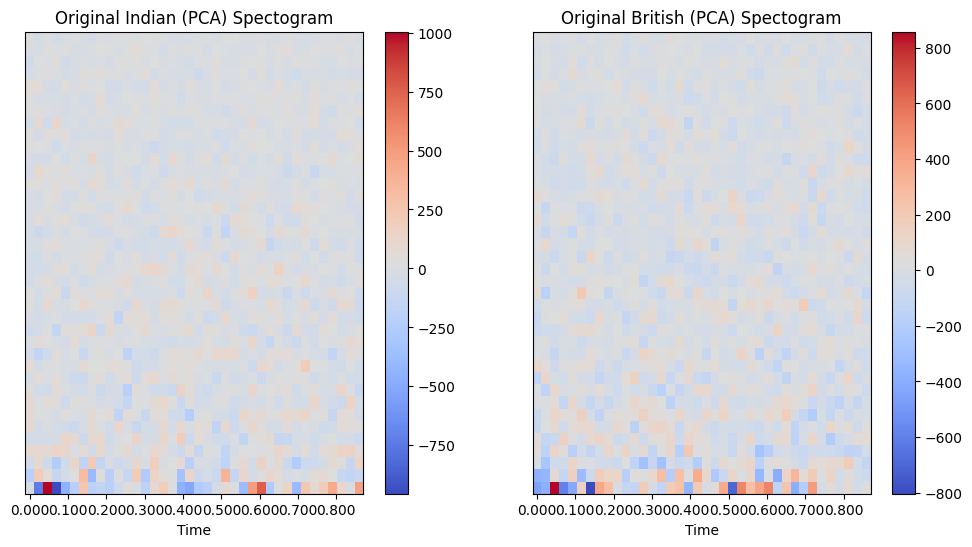

In [14]:
i = 400

# Plot original waveform
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Indian (PCA) Spectogram')
librosa.display.specshow(np.array(X[i]),sr=22050, x_axis='time')
plt.colorbar()


# Plot reconstructed waveform
plt.subplot(1, 2, 2)
plt.title('Original British (PCA) Spectogram')
librosa.display.specshow(np.array(y[i]),sr=22050, x_axis='time')
plt.colorbar()

plt.show()


In [12]:
pca_x = joblib.load('spectogram/pca_x.joblib')
pca_y = joblib.load('spectogram/pca_y.joblib')
n_components = joblib.load('spectogram/n_components.pkl')
n_freq =  joblib.load('spectogram/n_freq.pkl')
timesteps = joblib.load('spectogram/timesteps.pkl')
pad_len = joblib.load('spectogram/pad_length.pkl')
n_dim = joblib.load('spectogram/n_dim.pkl')

In [43]:
def reconstruct_pca(array, pca, n_components=n_components, n_freq=n_freq, timesteps=timesteps):
    return pca.inverse_transform(array.reshape(n_components)).ravel().reshape(n_freq, timesteps)

In [ ]:
i = 400

# Plot original spectogram
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.title('Original Indian Spectogram')
librosa.display.specshow(np.array(X_orig[i]),sr=22050, x_axis='time')
plt.colorbar()

# Plot original spectogram
plt.subplot(2, 2, 2)
plt.title('Reconstructed PCA Indian Spectogram')
librosa.display.specshow(reconstruct_pca(np.array(X[i]), pca_x),sr=22050, x_axis='time')
plt.colorbar()

# Plot reconstructed waveform
plt.subplot(2, 2, 3)
plt.title('Original British Spectogram')
librosa.display.specshow(np.array(y_orig[i]),sr=22050, x_axis='time')
plt.colorbar()


# Plot reconstructed waveform
plt.subplot(2, 2, 4)
plt.title('Reconstructed PCA British Spectogram')
librosa.display.specshow(reconstruct_pca(np.array(y[i]), pca_y),sr=22050, x_axis='time')
plt.colorbar()

plt.show()


In [13]:
n,c,d = X_train.shape

In [15]:
input_shape = (c, d, 1)

In [17]:
input_shape

(38, 38, 1)

In [18]:
batch_size = 32
epochs = 100
huber_delta = 0.45

In [19]:
@register_keras_serializable()
def custom_accent_conversion_loss(alpha=1.0, beta=0.1):
    """
    Custom loss function for accent conversion.
    
    Parameters:
        alpha (float): Weight parameter for the spectral loss component.
        beta (float): Weight parameter for the adversarial loss component.
    
    Returns:
        loss_function: Custom loss function.
    """
    
    def spectral_loss(y_true, y_pred):
        """
        Spectral loss function (e.g., L1 or L2 loss).
        
        Parameters:
            y_true: Ground truth spectral features.
            y_pred: Predicted spectral features.
        
        Returns:
            loss: Spectral loss.
        """
        # Calculate spectral loss (e.g., L1 loss)
        loss = K.mean(K.abs(y_true - y_pred))  # L1 loss
        
        return loss
    
    def adversarial_loss(y_true, y_pred):
        """
        Adversarial loss function (e.g., binary cross-entropy loss).
        
        Parameters:
            y_true: Ground truth labels (real or fake).
            y_pred: Predicted labels (discriminator output).
        
        Returns:
            loss: Adversarial loss.
        """
        # Calculate adversarial loss (binary cross-entropy)
        loss = K.mean(K.binary_crossentropy(y_true, y_pred))
        
        return loss
    
    def total_loss(y_true, y_pred):
        """
        Total loss combining spectral and adversarial losses.
        
        Parameters:
            y_true: Ground truth spectral features.
            y_pred: Predicted spectral features.
        
        Returns:
            loss: Total loss.
        """
        # Calculate spectral loss
        spec_loss = spectral_loss(y_true, y_pred)
        
        # Calculate adversarial loss
        adv_loss = adversarial_loss(y_true, y_pred)
        
        # Combine spectral and adversarial losses
        loss = alpha * spec_loss + beta * adv_loss
        
        return loss
    
    return total_loss

In [20]:
model = build_autoencoder_dropout_skip(input_shape)

Encoder Conv2D 1: (None, 38, 38, 32)
Encoder MaxPooling2D 1: (None, 19, 19, 32)
Encoder Conv2D 2: (None, 19, 19, 16)
Encoder MaxPooling2D 2: (None, 10, 10, 16)
Encoder Conv2D 3: (None, 10, 10, 8)
Encoder MaxPooling2D 3: (None, 5, 5, 8)
Skip First Conv2D: (None, 38, 38, 128)
Conv 1D after skip: (None, 38, 38, 1)
After making skip match x's size: (None, 5, 5, 8)
Decoder Conv2D 1: (None, 5, 5, 8)
Decoder UpSampling2D 1: (None, 10, 10, 8)
Decoder Conv2D 2: (None, 10, 10, 16)
Decoder UpSampling2D 2: (None, 20, 20, 16)
Decoder Conv2D 3: (None, 20, 20, 32)
Decoder UpSampling2D 3: (None, 40, 40, 32)
Decoder Conv2D 4: (None, 40, 40, 1)
Flatten: (None, 1600)
Dense layer: (None, 1444)
Output after reshaping:  (None, 38, 38, 1)


In [48]:
save_name = f'build_autoencoder_dropout_skip_custom_{epochs}.keras'

In [49]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_accent_conversion_loss(alpha=1.0, beta=0.1), metrics=['mean_absolute_error'])

In [50]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 38, 38, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 38,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 38, 38,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 19, 19,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 19, 19,    │      4,624 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 38, 38, 1) │         10 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 10,    │          0 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1444)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 10, 10, 8) │      2,056 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │    289,000 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10, 8) │         32 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 200)       │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 5, 5, 8)   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5, 8)   │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 5, 8)   │          0 │ max_pooling2d_2[… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,614,983 (9.98 MB)

 Trainable params: 2,614,759 (9.97 MB)

 Non-trainable params: 224 (896.00 B)

In [51]:
ts = time.time()
save_dir = f'models/{save_name}'
os.makedirs(save_dir, exist_ok=True)
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    
    def on_epoch_end(self, batch, logs={}):
        if batch % 10 == 1:
            file_name = f"run_{ts}_{save_name}_{batch}.keras"
            save_path = os.path.join(save_dir, file_name)
            model.save(save_path)
            self.acc.append(logs.get('acc'))

history = AccuracyHistory()


In [52]:
# Train the model
training_history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.7803 - mean_absolute_error: 0.7814 - val_loss: 0.7770 - val_mean_absolute_error: 0.7795
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.7808 - mean_absolute_error: 0.7807 - val_loss: 0.7770 - val_mean_absolute_error: 0.7795
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.7793 - mean_absolute_error: 0.7797 - val_loss: 0.7770 - val_mean_absolute_error: 0.7795
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.7826 - mean_absolute_error: 0.7822 - val_loss: 0.7770 - val_mean_absolute_error: 0.7795
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.7821 - mean_absolute_error: 0.7811 - val_loss: 0.7770 - val_mean_absolute_error: 0.7795
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.7818 - mean_absolute_error: 0.7814 - val_loss: 0.7770 - val_mean_absolute_error: 0.7795
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.7836 - mean_absolute_error: 0.7840 - v

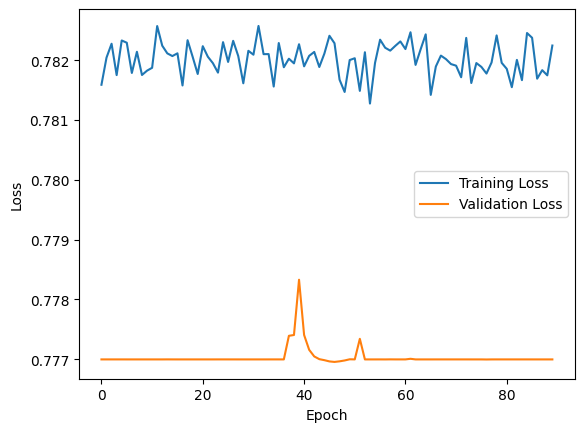

In [53]:
# Plot training loss and validation loss
plt.plot(training_history.history['loss'][10:], label='Training Loss')
plt.plot(training_history.history['val_loss'][10:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'graphs/spectogram/{'.'.join(save_name.split('.')[:1]+['png'])}')
plt.show()

In [54]:
model.save('models/spectogram/'+ save_name)

In [ ]:
# model = load_model('spectogram/'+ save_name, custom_objects={'total_loss': custom_accent_conversion_loss})

In [56]:
indian_test_file = r'E:\VSCode\Applied-ML\Project\Accent_classification_accentdb\accentdb_extended\data\indian\speaker_01\indian_s01_001.wav'
british_test_file = r'E:\VSCode\Applied-ML\Project\Accent_classification_accentdb\accentdb_extended\data\british\speaker_01\british_s01_001.wav'

In [57]:
test_spec_input = wav2spec(indian_test_file,pad_len=pad_len, pad_value=-80)
test_spec_output = wav2spec(british_test_file,pad_len=pad_len, pad_value=-80)

In [58]:
test_spec_input.shape

(513, 229)

In [59]:
pca_test_spec = pca_x.transform(test_spec_input.reshape(1,-1)).reshape(n_dim, n_dim)

In [60]:
normalized_test_spec = input_normalization_layer(pca_test_spec)

In [61]:
test_shape_length = normalized_test_spec.shape
if test_shape_length.__len__()==2:
    a,b = test_shape_length
elif test_shape_length.__len__()==3:
    _,a,b = test_shape_length

In [62]:
a,b

(38, 38)

In [63]:
test_prediction_pca = model.predict(normalized_test_spec.numpy().reshape(1,a,b,1))[0].reshape(n_dim, n_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


In [64]:
rescaled_test_pca = test_prediction_pca*np.sqrt(y_var) + y_mean

In [65]:
reconstructed_test_spec = reconstruct_pca(rescaled_test_pca, pca_y)

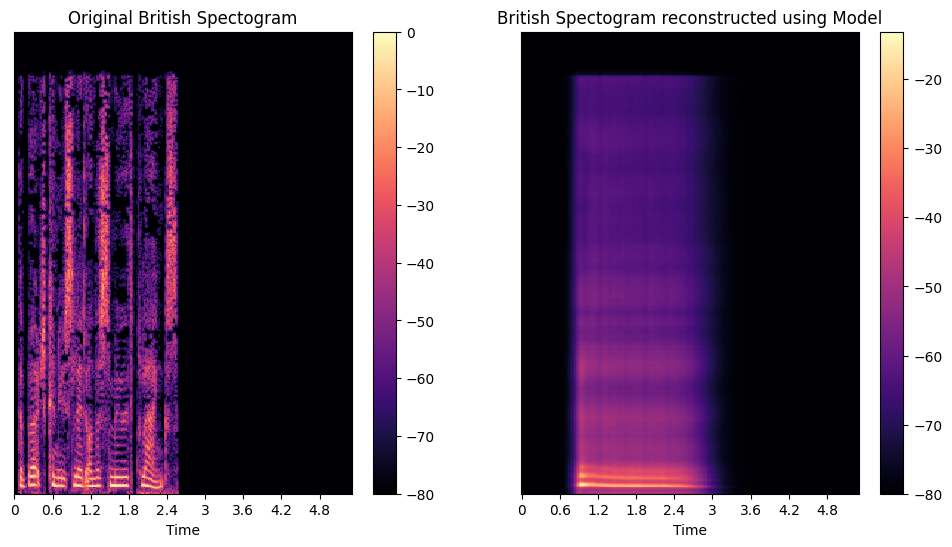

In [66]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(test_spec_output, x_axis='time')
plt.title('Original British Spectogram')
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(reconstructed_test_spec, x_axis='time')
plt.title('British Spectogram reconstructed using Model')
plt.colorbar()